## **IMPORT**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

def find_move_benchmark(fen: str, search_depth: int, versions: dict[int, str], plot_moves: bool = True, verbose: bool = True):
    result_df = pd.DataFrame()

    num_versions = len(versions)
    cols = 3
    rows = math.ceil(num_versions / cols)

    if plot_moves:
        fig, axs = plt.subplots(rows, cols, figsize = (8 * cols, 8 * rows), squeeze = False)

    row, col = 0, 0

    for version, version_name in versions.items():
        if verbose:
            print(f'Calculating version {version}: {version_name}')

        game = ChessGame(fen)
        start = time.time()
        move, score = find_move(game, search_depth, version=version)
        end = time.time()

        result_df = result_df.append({
            'Version'         : version,
            'Version name'    : version_name,
            'Search depth'    : search_depth,
            'Score'           : score,
            'Execution time'  : end - start,
            'No. Evaluations' : get_evaluation_count()
        }, ignore_index = True)

        moves = None if move is None else [move]

        if plot_moves:
            axs[row, col].set_title(version_name, fontdict={'fontsize': 20, 'fontweight': 'medium'})
            game.plot(moves=moves, ax=axs[row, col])
        
        col += 1
        if col >= cols:
            col = 0
            row += 1

    while plot_moves and row < rows:
        (axs[row, col]).set_visible(False)
        col += 1
        if col >= cols:
            col = 0
            row += 1

    return result_df

def find_move_benchmark_multiple_depth(fen: str, start_search_depth: int, versions: dict[int, str], time_threshold: float = 100.0, verbose: bool = True):
    result_df = pd.DataFrame()

    while len(versions) > 0:
        if verbose:
            print(f'Evaluating {len(versions)} version(s) (search depth: {start_search_depth})')

        current_depth_result_df = find_move_benchmark(fen, start_search_depth, versions, plot_moves = False, verbose = verbose)
        result_df = pd.concat([result_df, current_depth_result_df], ignore_index = True)
        
        good_versions = current_depth_result_df[current_depth_result_df['Execution time'] <= time_threshold]['Version'].to_list()
        new_versions = {}
        for good_version in good_versions:
            new_versions[good_version] = versions[good_version]
        versions = new_versions

        start_search_depth += 1

    return result_df.sort_values(by = ['Version','Search depth'], ignore_index = True)

## **TESTS**

In [2]:
versions = {
          0: 'Sequential',
          1: 'Sequential + Alpha-beta',
          2: 'Sequential + Alpha-beta + Move sorting',
          3: 'Parallel v1',
          4: 'Parallel v1 + Alpha-beta',
          5: 'Parallel v1 + Alpha-beta + Move sorting',
          6: 'Parallel v2',
          7: 'Parallel v2 + Alpha-beta',
          8: 'Parallel v2 + Alpha-beta + Move sorting',
          9: 'Parallel v3',
         10: 'Parallel v3 + Alpha-beta',
         11: 'Parallel v3 + Alpha-beta + Move sorting',
         12: 'Parallel v4',
         13: 'Parallel v4 + Alpha-beta',
         14: 'Parallel v4 + Alpha-beta + Move sorting',
         15: 'Parallel v5',
         16: 'Parallel v5 + Alpha-beta',
         17: 'Parallel v5 + Alpha-beta + Move sorting',
    }

Calculating version 10: Parallel v3 + Alpha-beta
Calculating version 11: Parallel v3 + Alpha-beta + Move sorting
Calculating version 16: Parallel v5 + Alpha-beta
Calculating version 17: Parallel v5 + Alpha-beta + Move sorting


,Version,Version name,Search depth,Score,Execution time,No. Evaluations
0,10,Parallel v3 + Alpha-beta,6,-1.0,7.399593,4317059
1,11,Parallel v3 + Alpha-beta + Move sorting,6,-1.0,1.061961,627030
2,16,Parallel v5 + Alpha-beta,6,-1.0,8.311819,3826140
3,17,Parallel v5 + Alpha-beta + Move sorting,6,-1.0,2.455726,601707


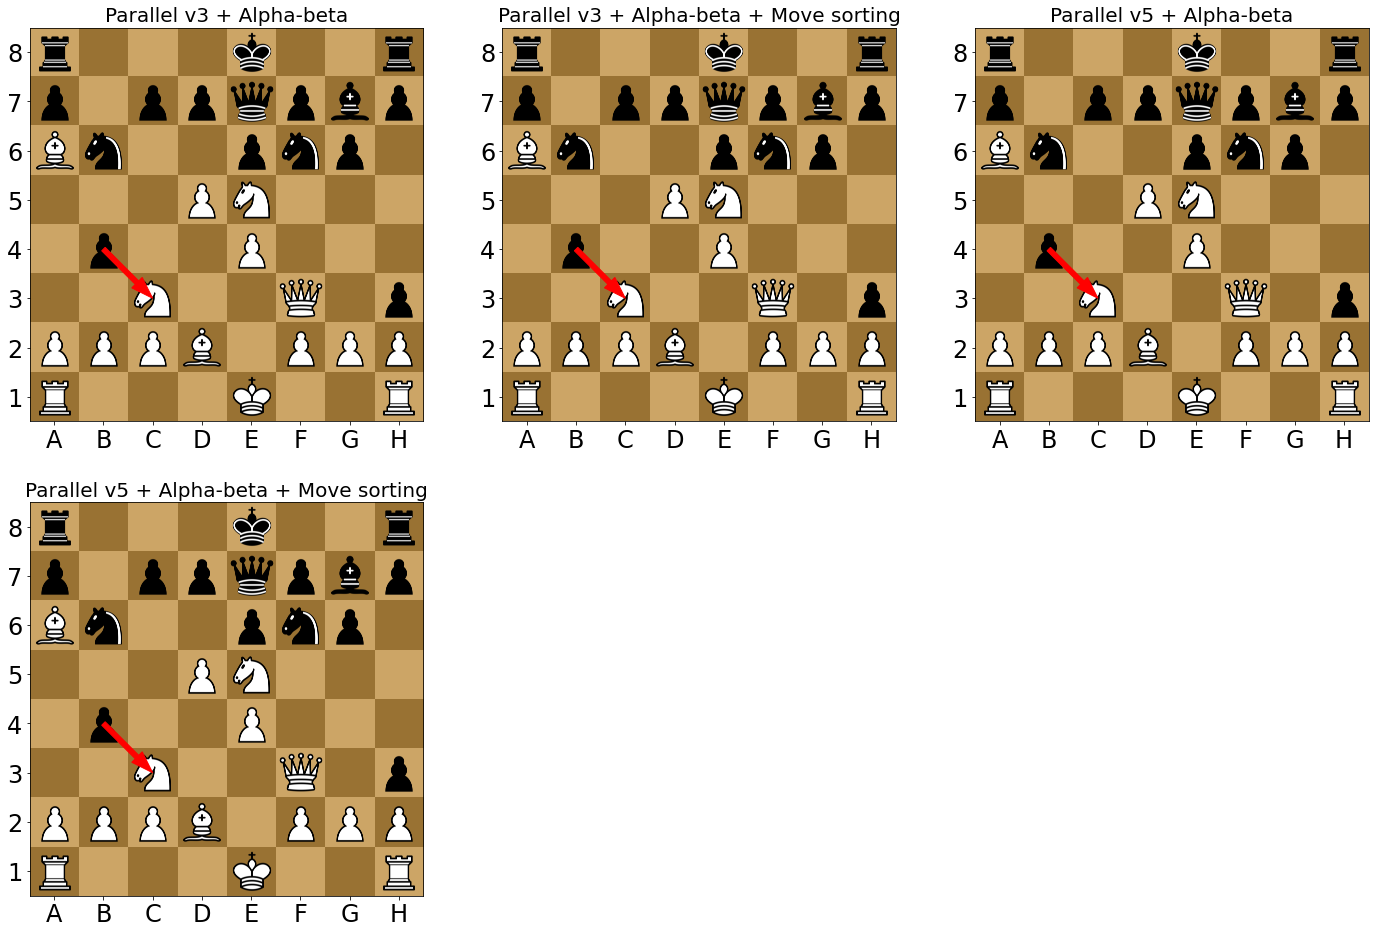

In [3]:
find_move_benchmark('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', 4, versions)

In [ ]:
result = find_move_benchmark_multiple_depth('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', 2, versions, time_threshold = 10.0)
result.to_csv('benchmark_results_multidepth.csv', index = False)
result

In [ ]:
plt.figure(figsize = (18, 12))

colors = [
    '#000000',
    '#ff0000',
    '#00ff00',
    '#0000ff',
    '#ffff00',
    '#ff00ff',
    '#00ffff',
    '#ffffff'
]

styles = [
    'solid',
    'dashed',
    'dotted'
]

for version, version_name in versions.items():
    df = result[result['Version'] == version]
    plt.plot(df['Search depth'], np.log10(df['Execution time']), label = version_name, color = colors[version // 3], linestyle = styles[version % 3])

locs, labels = plt.yticks()
plt.yticks(locs, np.power(10.0, locs))

plt.legend()
plt.grid()
plt.show()